In [4]:
import glob
import os
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from scipy.stats import yeojohnson
from sklearn.metrics import r2_score
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Import data

In [5]:
# Direct path to the specific shapefile
shp_file = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model_Outubro.shp'

# para guardar os csvs futuramente
processed_folder = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior'

# Verify it exists
if not os.path.exists(shp_file):
    raise FileNotFoundError(f"File not found: {shp_file}")

print(f"Importing {shp_file}...")

# Load shapefile into a GeoDataFrame
df_name = os.path.splitext(os.path.basename(shp_file))[0]
dataframes = {df_name: gpd.read_file(shp_file)}

Importing ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model_Outubro.shp...


In [6]:
cols = [
    "inidoy","enddoy","ros_p","1_3y_fir_p","3_8y_fir_p","8_ny_fir_p","elev_av","aspect_av",
    "landform","fuel_model","f_load_av","land_use","CBH_m_av","HigCC_p_av","LowCC_p_av",
    "MidCC_p_av","TotCC_p_av","BLH_m_av","Cape_av","Cin_av","gp_m2s2_av","t_2m_C_av",
    "d_2m_C_av","sP_hPa_av","wv10_kh_av","wdir10_av","wv100_k_av","wdir100_av","rh_2m_av",
    "VPD_Pa_av","dfmc_av","sW_1m_av","sW_3m_av","LCL_hPa_av","LCL_m_av","HDW_av",
    "Haines_av","wSv_9_av","wSdir_9_av","wSv_7_av","wSdir_7_av","wSv_5_av","wSdir_5_av",
    "wSv_1_av","wSdir_1_av","gT_s_9_av","gT_9_8_av","gT_8_7_av","gT_7_5_av","gT_5_3_av",
    "CMLG_av","LFC_hPa_av","CCL_hPa_av","EL_m_av","VentIdx_av","LiftIdx_av","gp_950_av",
    "gp_850_av","gp_700_av","gp_500_av","gp_300_av","rh_950_av","rh_850_av","rh_700_av",
    "rh_500_av","rh_300_av","t_950_av","t_850_av","t_700_av","t_500_av","t_300_av",
    "vwv_950_av","vwv_850_av","vwv_700_av","vwv_500_av","vwv_300_av","wv_950_av",
    "wv_850_av","wv_700_av","wv_500_av","wv_300_av","wdi_950_av","wdi_850_av","wdi_700_av",
    "wdi_500_av","wdi_300_av","wv_10_av","wdi_10_av","wv_100_av","wdi_100_av","BLH_m_rt",
    "Recirc","CircVar","CircStd_dg","ros_p_lg1","ros_p_lg2","ros_p_lg3","ros_p_lg4",
    "ros_p_lg5","ros_p_lg6","ros_p_lg7","ros_p_lg8","ros_p_lg9","ros_p_lg10","duration"
]

for name, df in dataframes.items():
    valid_cols = [c for c in cols if c in df.columns]
    df[valid_cols] = df[valid_cols].replace([-1, -999], np.nan)
    dataframes[name] = df

### log transformation

In [7]:
import os
import numpy as np
import geopandas as gpd

cols_log = [
    "ros_p","1_3y_fir_p","3_8y_fir_p","8_ny_fir_p","elev_av",
    "f_load_av","CBH_m_av","HigCC_p_av","LowCC_p_av",
    "MidCC_p_av","TotCC_p_av","BLH_m_av","Cape_av","Cin_av","gp_m2s2_av","t_2m_C_av",
    "d_2m_C_av","sP_hPa_av","wv10_kh_av","wdir10_av","wv100_k_av","wdir100_av","rh_2m_av",
    "VPD_Pa_av","dfmc_av","sW_1m_av","sW_3m_av","LCL_hPa_av","LCL_m_av","HDW_av",
    "wSv_9_av","wSdir_9_av","wSv_7_av","wSdir_7_av","wSv_5_av","wSdir_5_av",
    "wSv_1_av","wSdir_1_av","gT_s_9_av","gT_9_8_av","gT_8_7_av","gT_7_5_av","gT_5_3_av",
    "CMLG_av","LFC_hPa_av","CCL_hPa_av","EL_m_av","VentIdx_av","LiftIdx_av","gp_950_av",
    "gp_850_av","gp_700_av","gp_500_av","gp_300_av","rh_950_av","rh_850_av","rh_700_av",
    "rh_500_av","rh_300_av","t_950_av","t_850_av","t_700_av","t_500_av","t_300_av",
    "vwv_950_av","vwv_850_av","vwv_700_av","vwv_500_av","vwv_300_av","wv_950_av",
    "wv_850_av","wv_700_av","wv_500_av","wv_300_av","wdi_950_av","wdi_850_av","wdi_700_av",
    "wdi_500_av","wdi_300_av","wv_10_av","wdi_10_av","wv_100_av","wdi_100_av","BLH_m_rt",
    "Recirc","CircVar","CircStd_dg","ros_p_lg1","ros_p_lg2","ros_p_lg3","ros_p_lg4",
    "ros_p_lg5","ros_p_lg6","ros_p_lg7","ros_p_lg8","ros_p_lg9","ros_p_lg10","duration"
]

base = os.path.splitext(os.path.basename(shp_file))[0]
print(f"Importing {base}...")

# Carregar shapefile completo
gdf = gpd.read_file(shp_file)

# Selecionar apenas colunas válidas
valid_cols = [c for c in cols_log if c in gdf.columns]

# Substituir valores inválidos antes da transformação
gdf[valid_cols] = gdf[valid_cols].replace([-1, -999], np.nan)

# Aplicar transformação sign(x) * log(|x| + 1)
gdf[valid_cols] = gdf[valid_cols].applymap(lambda x: np.sign(x) * np.log(np.abs(x) + 1) if pd.notna(x) else np.nan)

# Guardar com sufixo _log
output_path = os.path.join(processed_folder, f"{base}_log.shp")
print(f"Saving {output_path}...")
gdf.to_file(output_path)

print("All files processed.")

Importing PT-FireProg_v2.1_L2_model_Outubro...
Saving ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior\PT-FireProg_v2.1_L2_model_Outubro_log.shp...
All files processed.


C:\Users\dias3\AppData\Local\Temp\ipykernel_1196\4117197361.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gdf[valid_cols] = gdf[valid_cols].applymap(lambda x: np.sign(x) * np.log(np.abs(x) + 1) if pd.notna(x) else np.nan)


### Plot ROS_P Distribution


Analyzing PT-FireProg_v2.1_L2_model_Outubro...


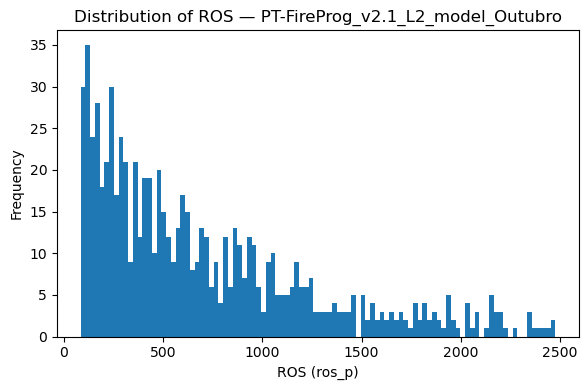

D’Agostino–Pearson Normality Test for ros_p
Statistic: 122.3514
p-value: 2.7023e-27
Reject H₀ (data is likely not normal).


In [8]:
for name, df in dataframes.items():
    print(f"\nAnalyzing {name}...")

    if "ros_p" not in df.columns:
        print("Skipped — 'ros_p' column not found.")
        continue

    # Convert ros_p to numeric and drop NaNs
    ros_data = pd.to_numeric(df["ros_p"], errors="coerce").dropna()

    if len(ros_data) == 0:
        print("Skipped — no valid 'ros_p' values.")
        continue

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(ros_data, bins=100)
    plt.title(f"Distribution of ROS — {name}")
    plt.xlabel("ROS (ros_p)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Perform D’Agostino–Pearson normality test
    stat, p_value = stats.normaltest(ros_data)

    print("D’Agostino–Pearson Normality Test for ros_p")
    print(f"Statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4e}")

    if p_value > 0.05:
        print("Fail to reject H₀ (data appears normal).")
    else:
        print("Reject H₀ (data is likely not normal).")

### Compute descriptive statistics (mean, median, quartiles, std, skewness, kurtosis)

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import geopandas as gpd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from typing import Dict, List, Optional

# ========== CONFIGURATION ==========
CATEGORICAL_VARIABLES = [
    'Haines_av', 'burn_perio', 'land_use', 'zp_link', 
    'year', 'fuel_model', 'landform'
]

SHP_DIR = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior'
OUTPUT_DIR = '../../Data/Data_Exploration'

# ========== UTILITY FUNCTIONS ==========
def _to_numeric_series(s: pd.Series) -> pd.Series:
    """Convert series to numeric, coercing errors to NaN."""
    return pd.to_numeric(s, errors='coerce')

def _sign_log_transform(series: pd.Series) -> pd.Series:
    """Apply sign log transformation: sign(x) * log(|x| + 1)."""
    series_numeric = _to_numeric_series(series)
    
    # Handle NaN values
    valid_mask = series_numeric.notna()
    result = series_numeric.copy()
    
    # Apply sign log transformation: sign(x) * log(|x| + 1)
    result[valid_mask] = np.sign(series_numeric[valid_mask]) * np.log1p(np.abs(series_numeric[valid_mask]))
    
    return result

def load_shapefiles(shp_dir: str) -> Dict[str, gpd.GeoDataFrame]:
    """Load all shapefiles from directory."""
    if not os.path.exists(shp_dir):
        raise FileNotFoundError(f"Directory not found: {shp_dir}")
    
    shp_files = [f for f in Path(shp_dir).glob('*.shp')]

    if not shp_files:
        raise FileNotFoundError(f"No shapefiles found in: {shp_dir}")
    
    print(f"Found {len(shp_files)} shapefiles:")
    dataframes = {}
    
    for shp_file in shp_files:
        df_name = shp_file.stem
        print(f"  - Loading {df_name}...")
        dataframes[df_name] = gpd.read_file(shp_file)
    
    print(f"Successfully loaded {len(dataframes)} shapefiles\n")
    return dataframes

def preprocess_dataframe(df: gpd.GeoDataFrame, categorical_vars: List[str]) -> gpd.GeoDataFrame:
    """Preprocess dataframe by converting object columns to numeric where possible."""
    df_processed = df.copy()
    
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object' and col not in categorical_vars:
            converted = pd.to_numeric(df_processed[col], errors='coerce')
            if not converted.isna().all():
                df_processed[col] = converted
    
    return df_processed

def calculate_numeric_stats(df: pd.DataFrame, numeric_cols: List[str]) -> pd.DataFrame:
    """Calculate descriptive statistics for numeric variables."""
    stats_df = pd.DataFrame(index=numeric_cols)
    
    if len(numeric_cols) == 0:
        return stats_df
    
    # Sample size statistics
    stats_df['n'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).count())
    stats_df['n_total'] = len(df)
    stats_df['n_missing'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).isna().sum())
    stats_df['pct_missing'] = (stats_df['n_missing'] / stats_df['n_total']) * 100
    stats_df['pct_complete'] = (stats_df['n'] / stats_df['n_total']) * 100
    
    # Basic statistics
    stats_df['mean'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).mean())
    stats_df['median'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).median())
    stats_df['std'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).std())
    stats_df['var'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).var())
    stats_df['sem'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).sem())  # Standard error of mean
    stats_df['cv'] = (stats_df['std'] / stats_df['mean']) * 100  # Coefficient of variation
    
    # Quantiles
    stats_df['q01'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.01))
    stats_df['q05'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.05))
    stats_df['q10'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.10))
    stats_df['q25'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.25))
    stats_df['q75'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.75))
    stats_df['q90'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.90))
    stats_df['q95'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.95))
    stats_df['q99'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.99))
    stats_df['min'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).min())
    stats_df['max'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).max())
    
    # Range statistics
    stats_df['range'] = stats_df['max'] - stats_df['min']
    stats_df['AIQ'] = stats_df['q75'] - stats_df['q25']  # Interquartile range
    stats_df['qcd'] = (stats_df['q75'] - stats_df['q25']) / (stats_df['q75'] + stats_df['q25'])  # Quartile coefficient of dispersion
    
    # Distribution statistics
    stats_df['skewness'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).skew())
    stats_df['kurtosis'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).kurtosis())
    
    # Data quality metrics
    stats_df['n_zeros'] = df[numeric_cols].apply(lambda col: (_to_numeric_series(col) == 0).sum())
    stats_df['pct_zeros'] = (stats_df['n_zeros'] / stats_df['n_total']) * 100
    stats_df['n_negative'] = df[numeric_cols].apply(lambda col: (_to_numeric_series(col) < 0).sum())
    stats_df['pct_negative'] = (stats_df['n_negative'] / stats_df['n_total']) * 100
    stats_df['n_positive'] = df[numeric_cols].apply(lambda col: (_to_numeric_series(col) > 0).sum())
    stats_df['pct_positive'] = (stats_df['n_positive'] / stats_df['n_total']) * 100
    
    # Outlier detection using IQR method
    for col in numeric_cols:
        col_series = _to_numeric_series(df[col])
        q1 = col_series.quantile(0.25)
        q3 = col_series.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        n_outliers = ((col_series < lower_bound) | (col_series > upper_bound)).sum()
        stats_df.loc[col, 'n_outliers'] = n_outliers
        stats_df.loc[col, 'pct_outliers'] = (n_outliers / stats_df.loc[col, 'n']) * 100 if stats_df.loc[col, 'n'] > 0 else 0
    
    # Normality tests
    for col in numeric_cols:
        col_series = _to_numeric_series(df[col])
        valid_data = col_series.dropna()
        n_valid = len(valid_data)
        
        if n_valid >= 8:
            try:
                # D'Agostino-Pearson normality test
                statistic, p_value = stats.normaltest(valid_data)
                stats_df.loc[col, 'normality_stat'] = statistic
                stats_df.loc[col, 'normality_p'] = p_value
                
                # Shapiro-Wilk test (for smaller samples)
                if n_valid >= 3 and n_valid <= 5000:
                    shapiro_stat, shapiro_p = stats.shapiro(valid_data)
                    stats_df.loc[col, 'shapiro_stat'] = shapiro_stat
                    stats_df.loc[col, 'shapiro_p'] = shapiro_p
                else:
                    stats_df.loc[col, 'shapiro_stat'] = np.nan
                    stats_df.loc[col, 'shapiro_p'] = np.nan
                    
            except Exception as e:
                print(f"Normality test failed for {col}: {e}")
                stats_df.loc[col, 'normality_stat'] = np.nan
                stats_df.loc[col, 'normality_p'] = np.nan
                stats_df.loc[col, 'shapiro_stat'] = np.nan
                stats_df.loc[col, 'shapiro_p'] = np.nan
        else:
            stats_df.loc[col, 'normality_stat'] = np.nan
            stats_df.loc[col, 'normality_p'] = np.nan
            stats_df.loc[col, 'shapiro_stat'] = np.nan
            stats_df.loc[col, 'shapiro_p'] = np.nan
    
    return stats_df

def calculate_categorical_stats(df: pd.DataFrame, categorical_cols: List[str]) -> pd.DataFrame:
    """Calculate descriptive statistics for categorical variables."""
    stats_df = pd.DataFrame(index=categorical_cols)
    
    if len(categorical_cols) == 0:
        return stats_df
    
    # Basic sample information
    stats_df['n_total'] = len(df)
    stats_df['n'] = df[categorical_cols].apply(lambda col: col.notna().sum())
    stats_df['n_missing'] = df[categorical_cols].apply(lambda col: col.isna().sum())
    stats_df['pct_missing'] = (stats_df['n_missing'] / stats_df['n_total']) * 100
    stats_df['pct_complete'] = (stats_df['n'] / stats_df['n_total']) * 100
    
    for col in categorical_cols:
        # Uniqueness statistics
        stats_df.loc[col, 'n_unique'] = df[col].nunique()
        stats_df.loc[col, 'pct_unique'] = (stats_df.loc[col, 'n_unique'] / stats_df.loc[col, 'n']) * 100 if stats_df.loc[col, 'n'] > 0 else 0
        
        # Mode statistics
        mode_result = df[col].mode()
        if len(mode_result) > 0:
            stats_df.loc[col, 'mode'] = mode_result[0]
            stats_df.loc[col, 'mode_freq'] = df[col].value_counts().iloc[0]
            stats_df.loc[col, 'mode_pct'] = (stats_df.loc[col, 'mode_freq'] / stats_df.loc[col, 'n']) * 100
            
            # Second most frequent value
            value_counts = df[col].value_counts()
            if len(value_counts) > 1:
                stats_df.loc[col, 'mode2'] = value_counts.index[1]
                stats_df.loc[col, 'mode2_freq'] = value_counts.iloc[1]
                stats_df.loc[col, 'mode2_pct'] = (stats_df.loc[col, 'mode2_freq'] / stats_df.loc[col, 'n']) * 100
            else:
                stats_df.loc[col, 'mode2'] = np.nan
                stats_df.loc[col, 'mode2_freq'] = np.nan
                stats_df.loc[col, 'mode2_pct'] = np.nan
        else:
            stats_df.loc[col, 'mode'] = np.nan
            stats_df.loc[col, 'mode_freq'] = np.nan
            stats_df.loc[col, 'mode_pct'] = np.nan
            stats_df.loc[col, 'mode2'] = np.nan
            stats_df.loc[col, 'mode2_freq'] = np.nan
            stats_df.loc[col, 'mode2_pct'] = np.nan
        
        # Entropy (measure of randomness/uncertainty)
        value_counts = df[col].value_counts(normalize=True)
        entropy = -np.sum(value_counts * np.log2(value_counts))
        stats_df.loc[col, 'entropy'] = entropy
        stats_df.loc[col, 'max_entropy'] = np.log2(stats_df.loc[col, 'n_unique']) if stats_df.loc[col, 'n_unique'] > 0 else 0
        stats_df.loc[col, 'rel_entropy'] = entropy / stats_df.loc[col, 'max_entropy'] if stats_df.loc[col, 'max_entropy'] > 0 else 0
    
    return stats_df

def calculate_ros_correlations(df: pd.DataFrame, numeric_cols: List[str], 
                             categorical_cols: List[str]) -> pd.DataFrame:
    """Calculate correlations and R² with ros_p variable."""
    stats_df = pd.DataFrame(index=list(numeric_cols) + categorical_cols)
    
    if 'ros_p' not in df.columns:
        # Initialize all correlation columns with NaN
        correlation_columns = [
            'corr_ros_p', 'R2_ros_p', 'corr_n', 'corr_p_value',
            'corr_log_ros_p', 'R2_log_ros_p', 'corr_log_n', 'corr_log_ros_p_value'
        ]
        for col in correlation_columns:
            stats_df[col] = np.nan
        return stats_df
    
    # Original ros_p series
    ros_series = pd.to_numeric(df['ros_p'], errors='coerce')
    ros_series = ros_series.replace([np.inf, -np.inf], np.nan)
    
    # Sign log-transformed ros_p series: sign(x) * log(|x| + 1)
    ros_log_series = _sign_log_transform(df['ros_p'])
    ros_log_series = ros_log_series.replace([np.inf, -np.inf], np.nan)
    
    # Numeric variables: Pearson correlation with original and log-transformed ros_p
    for col in numeric_cols:
        if col != 'ros_p':
            col_series = pd.to_numeric(df[col], errors='coerce')
            
            # Correlation with original ros_p
            valid_idx = ros_series.notna() & col_series.notna()
            n_valid = valid_idx.sum()
            
            if n_valid > 1:
                corr = ros_series[valid_idx].corr(col_series[valid_idx])
                stats_df.loc[col, 'corr_ros_p'] = corr
                stats_df.loc[col, 'R2_ros_p'] = corr ** 2
                stats_df.loc[col, 'corr_n'] = n_valid
                
                # Calculate p-value for correlation
                if n_valid > 2:
                    try:
                        corr_test = stats.pearsonr(ros_series[valid_idx], col_series[valid_idx])
                        stats_df.loc[col, 'corr_p_value'] = corr_test.pvalue
                    except:
                        stats_df.loc[col, 'corr_p_value'] = np.nan
                else:
                    stats_df.loc[col, 'corr_p_value'] = np.nan
            else:
                stats_df.loc[col, 'corr_ros_p'] = np.nan
                stats_df.loc[col, 'R2_ros_p'] = np.nan
                stats_df.loc[col, 'corr_n'] = np.nan
                stats_df.loc[col, 'corr_p_value'] = np.nan
            
            # Correlation with log-transformed ros_p
            valid_log_idx = ros_log_series.notna() & col_series.notna()
            n_log_valid = valid_log_idx.sum()
            
            if n_log_valid > 1:
                corr_log = ros_log_series[valid_log_idx].corr(col_series[valid_log_idx])
                stats_df.loc[col, 'corr_log_ros_p'] = corr_log
                stats_df.loc[col, 'R2_log_ros_p'] = corr_log ** 2
                stats_df.loc[col, 'corr_log_n'] = n_log_valid
                
                # Calculate p-value for log correlation
                if n_log_valid > 2:
                    try:
                        corr_log_test = stats.pearsonr(ros_log_series[valid_log_idx], col_series[valid_log_idx])
                        stats_df.loc[col, 'corr_log_ros_p_value'] = corr_log_test.pvalue
                    except:
                        stats_df.loc[col, 'corr_log_ros_p_value'] = np.nan
                else:
                    stats_df.loc[col, 'corr_log_ros_p_value'] = np.nan
            else:
                stats_df.loc[col, 'corr_log_ros_p'] = np.nan
                stats_df.loc[col, 'R2_log_ros_p'] = np.nan
                stats_df.loc[col, 'corr_log_n'] = np.nan
                stats_df.loc[col, 'corr_log_ros_p_value'] = np.nan
    
    # Categorical variables: Eta-squared with original and log-transformed ros_p
    for col in categorical_cols:
        try:
            # For original ros_p
            valid_idx = ros_series.notna() & df[col].notna()
            n_valid = valid_idx.sum()
            
            if n_valid > 1:
                groups = df.loc[valid_idx, col]
                values = ros_series[valid_idx]
                
                if groups.nunique() >= 2:
                    # Calculate eta-squared for original ros_p
                    group_means = values.groupby(groups).mean()
                    overall_mean = values.mean()
                    
                    ss_between = sum(values.groupby(groups).size() * (group_means - overall_mean) ** 2)
                    ss_total = sum((values - overall_mean) ** 2)
                    
                    if ss_total > 0:
                        eta_squared = ss_between / ss_total
                        stats_df.loc[col, 'corr_ros_p'] = np.sqrt(eta_squared)
                        stats_df.loc[col, 'R2_ros_p'] = eta_squared
                        stats_df.loc[col, 'corr_n'] = n_valid
                        
                        # ANOVA test for categorical variables
                        try:
                            groups_list = [values[groups == category] for category in groups.unique()]
                            if all(len(group) > 0 for group in groups_list):
                                f_stat, p_value = stats.f_oneway(*groups_list)
                                stats_df.loc[col, 'anova_p_value'] = p_value
                            else:
                                stats_df.loc[col, 'anova_p_value'] = np.nan
                        except:
                            stats_df.loc[col, 'anova_p_value'] = np.nan
                    else:
                        stats_df.loc[col, 'corr_ros_p'] = np.nan
                        stats_df.loc[col, 'R2_ros_p'] = np.nan
                        stats_df.loc[col, 'corr_n'] = np.nan
                        stats_df.loc[col, 'anova_p_value'] = np.nan
                else:
                    stats_df.loc[col, 'corr_ros_p'] = np.nan
                    stats_df.loc[col, 'R2_ros_p'] = np.nan
                    stats_df.loc[col, 'corr_n'] = np.nan
                    stats_df.loc[col, 'anova_p_value'] = np.nan
            else:
                stats_df.loc[col, 'corr_ros_p'] = np.nan
                stats_df.loc[col, 'R2_ros_p'] = np.nan
                stats_df.loc[col, 'corr_n'] = np.nan
                stats_df.loc[col, 'anova_p_value'] = np.nan
            
            # For log-transformed ros_p
            valid_log_idx = ros_log_series.notna() & df[col].notna()
            n_log_valid = valid_log_idx.sum()
            
            if n_log_valid > 1:
                groups_log = df.loc[valid_log_idx, col]
                values_log = ros_log_series[valid_log_idx]
                
                if groups_log.nunique() >= 2:
                    # Calculate eta-squared for log-transformed ros_p
                    group_means_log = values_log.groupby(groups_log).mean()
                    overall_mean_log = values_log.mean()
                    
                    ss_between_log = sum(values_log.groupby(groups_log).size() * (group_means_log - overall_mean_log) ** 2)
                    ss_total_log = sum((values_log - overall_mean_log) ** 2)
                    
                    if ss_total_log > 0:
                        eta_squared_log = ss_between_log / ss_total_log
                        stats_df.loc[col, 'corr_log_ros_p'] = np.sqrt(eta_squared_log)
                        stats_df.loc[col, 'R2_log_ros_p'] = eta_squared_log
                        stats_df.loc[col, 'corr_log_n'] = n_log_valid
                        
                        # ANOVA test for log-transformed values
                        try:
                            groups_log_list = [values_log[groups_log == category] for category in groups_log.unique()]
                            if all(len(group) > 0 for group in groups_log_list):
                                f_stat_log, p_value_log = stats.f_oneway(*groups_log_list)
                                stats_df.loc[col, 'anova_log_ros_p_value'] = p_value_log
                            else:
                                stats_df.loc[col, 'anova_log_ros_p_value'] = np.nan
                        except:
                            stats_df.loc[col, 'anova_log_ros_p_value'] = np.nan
                    else:
                        stats_df.loc[col, 'corr_log_ros_p'] = np.nan
                        stats_df.loc[col, 'R2_log_ros_p'] = np.nan
                        stats_df.loc[col, 'corr_log_n'] = np.nan
                        stats_df.loc[col, 'anova_log_ros_p_value'] = np.nan
                else:
                    stats_df.loc[col, 'corr_log_ros_p'] = np.nan
                    stats_df.loc[col, 'R2_log_ros_p'] = np.nan
                    stats_df.loc[col, 'corr_log_n'] = np.nan
                    stats_df.loc[col, 'anova_log_ros_p_value'] = np.nan
            else:
                stats_df.loc[col, 'corr_log_ros_p'] = np.nan
                stats_df.loc[col, 'R2_log_ros_p'] = np.nan
                stats_df.loc[col, 'corr_log_n'] = np.nan
                stats_df.loc[col, 'anova_log_ros_p_value'] = np.nan
                
        except Exception as e:
            print(f"R² calculation failed for categorical {col}: {e}")
            # Set all correlation columns to NaN for this variable
            correlation_cols = [
                'corr_ros_p', 'R2_ros_p', 'corr_n', 'anova_p_value',
                'corr_log_ros_p', 'R2_log_ros_p', 'corr_log_n', 'corr_log_ros_p_value', 'anova_log_ros_p_value'
            ]
            for corr_col in correlation_cols:
                stats_df.loc[col, corr_col] = np.nan
    
    return stats_df

def calculate_vif(stats_df: pd.DataFrame) -> pd.DataFrame:
    """Calculate Variance Inflation Factor for both original and log-transformed R²."""
    stats_df = stats_df.copy()
    
    # VIF for original ros_p
    if 'R2_ros_p' in stats_df.columns:
        for col in stats_df.index:
            if col != 'ros_p':
                r2 = stats_df.loc[col, 'R2_ros_p']
                if pd.notna(r2) and r2 < 1.0:
                    stats_df.loc[col, 'VIF'] = 1.0 / (1.0 - r2)
                else:
                    stats_df.loc[col, 'VIF'] = np.nan
    
    # VIF for log-transformed ros_p
    if 'R2_log_ros_p' in stats_df.columns:
        for col in stats_df.index:
            if col != 'ros_p':
                r2_log = stats_df.loc[col, 'R2_log_ros_p']
                if pd.notna(r2_log) and r2_log < 1.0:
                    stats_df.loc[col, 'VIF_log_ros_p'] = 1.0 / (1.0 - r2_log)
                else:
                    stats_df.loc[col, 'VIF_log_ros_p'] = np.nan
    
    if 'ros_p' in stats_df.index:
        stats_df.loc['ros_p', 'VIF'] = np.nan
        stats_df.loc['ros_p', 'VIF_log_ros_p'] = np.nan
    
    return stats_df

def generate_descriptive_stats(df: gpd.GeoDataFrame, name: str) -> pd.DataFrame:
    """Generate comprehensive descriptive statistics for a dataframe."""
    print(f"Processing descriptive statistics for {name}...")
    
    # Preprocess data
    df_processed = preprocess_dataframe(df, CATEGORICAL_VARIABLES)
    
    # Identify columns
    categorical_cols = [col for col in CATEGORICAL_VARIABLES if col in df_processed.columns]
    numeric_cols = df_processed.select_dtypes(include=['number']).columns.difference(['sdate'] + categorical_cols).tolist()
    all_cols = numeric_cols + categorical_cols
    
    if len(all_cols) == 0:
        print(f"No valid columns found in {name}. Skipping.")
        return pd.DataFrame()
    
    # Calculate statistics
    desc_stats = pd.DataFrame(index=all_cols)
    
    # Numeric statistics
    numeric_stats = calculate_numeric_stats(df_processed, numeric_cols)
    desc_stats = desc_stats.combine_first(numeric_stats)
    
    # Categorical statistics
    categorical_stats = calculate_categorical_stats(df_processed, categorical_cols)
    desc_stats = desc_stats.combine_first(categorical_stats)
    
    # ROS correlations (both original and log-transformed)
    ros_corrs = calculate_ros_correlations(df_processed, numeric_cols, categorical_cols)
    desc_stats = desc_stats.combine_first(ros_corrs)
    
    # VIF calculation (both original and log-transformed)
    desc_stats = calculate_vif(desc_stats)
    
    # Add variable type
    desc_stats['var_type'] = 'numeric'
    desc_stats.loc[categorical_cols, 'var_type'] = 'categorical'
    
    # Final column ordering
    return organize_columns(desc_stats)

def organize_columns(stats_df: pd.DataFrame) -> pd.DataFrame:
    """Organize columns in a logical order."""
    # Sample size columns
    sample_cols = ['n', 'n_total', 'n_missing', 'pct_missing', 'pct_complete']
    
    # Numeric statistics columns
    numeric_stat_cols = [
        'mean', 'median', 'std', 'var', 'sem', 'cv',
        'min', 'max', 'range', 'q01', 'q05', 'q10', 'q25', 
        'q75', 'q90', 'q95', 'q99', 'AIQ', 'qcd',
        'skewness', 'kurtosis', 'n_zeros', 'pct_zeros', 
        'n_negative', 'pct_negative', 'n_positive', 'pct_positive',
        'n_outliers', 'pct_outliers', 'normality_stat', 'normality_p',
        'shapiro_stat', 'shapiro_p'
    ]
    
    # Categorical statistics columns
    categorical_stat_cols = [
        'n_unique', 'pct_unique', 'mode', 'mode_freq', 'mode_pct',
        'mode2', 'mode2_freq', 'mode2_pct', 'entropy', 'max_entropy', 'rel_entropy'
    ]
    
    # Correlation and relationship columns - ORIGINAL ros_p
    correlation_cols_original = [
        'corr_ros_p', 'R2_ros_p', 'corr_n', 'corr_p_value', 'anova_p_value', 'VIF'
    ]
    
    # Correlation and relationship columns - LOG-TRANSFORMED ros_p
    correlation_cols_log = [
        'corr_log_ros_p', 'R2_log_ros_p', 'corr_log_n', 'corr_log_ros_p_value', 
        'anova_log_ros_p_value', 'VIF_log_ros_p'
    ]
    
    # Type column
    type_cols = ['var_type']
    
    # Combine all columns in logical order
    final_cols = (sample_cols + numeric_stat_cols + categorical_stat_cols + 
                 correlation_cols_original + correlation_cols_log + type_cols)
    
    # Only include columns that actually exist in the dataframe
    available_cols = [col for col in final_cols if col in stats_df.columns]
    
    return stats_df[available_cols]

def save_statistics(all_stats: Dict[str, pd.DataFrame], output_dir: str):
    """Save all statistics to CSV files."""
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for name, stats_df in all_stats.items():
        output_path = Path(output_dir) / f'descriptive_stats_{name}.csv'
        stats_df.to_csv(output_path)
        print(f"Saved {output_path}")

# ========== MAIN EXECUTION ==========
def main():
    """Main function to execute the descriptive statistics pipeline."""
    try:
        # Load shapefiles
        dataframes = load_shapefiles(SHP_DIR)
        
        # Generate statistics for each dataframe
        all_stats = {}
        for name, df in dataframes.items():
            stats_df = generate_descriptive_stats(df, name)
            if not stats_df.empty:
                all_stats[name] = stats_df
        
        # Save results
        save_statistics(all_stats, OUTPUT_DIR)
        print("All descriptive statistics have been generated and saved.")
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        raise

if __name__ == "__main__":
    main()

Found 6 shapefiles:
  - Loading PT-FireProg_v2.1_L2_final...
  - Loading PT-FireProg_v2.1_L2_model...
  - Loading PT-FireProg_v2.1_L2_model_log...
  - Loading PT-FireProg_v2.1_L2_model_Outubro...
  - Loading PT-FireProg_v2.1_L2_model_Outubro_log...
  - Loading PT-FireProg_v2.1_L2_short...
Successfully loaded 6 shapefiles

Processing descriptive statistics for PT-FireProg_v2.1_L2_final...
Processing descriptive statistics for PT-FireProg_v2.1_L2_model...
Processing descriptive statistics for PT-FireProg_v2.1_L2_model_log...
Processing descriptive statistics for PT-FireProg_v2.1_L2_model_Outubro...
Processing descriptive statistics for PT-FireProg_v2.1_L2_model_Outubro_log...
Processing descriptive statistics for PT-FireProg_v2.1_L2_short...
Saved ..\..\Data\Data_Exploration\descriptive_stats_PT-FireProg_v2.1_L2_final.csv
Saved ..\..\Data\Data_Exploration\descriptive_stats_PT-FireProg_v2.1_L2_model.csv
Saved ..\..\Data\Data_Exploration\descriptive_stats_PT-FireProg_v2.1_L2_model_log.csv


## Fazer plots dashboard

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display, clear_output

# Carregar DataFrame transformado
df_transformed = dataframes["PT-FireProg_v2.1_L2_model"]

# Selecionar apenas colunas numéricas
numeric_df = df_transformed.select_dtypes(include=[np.number])
if numeric_df.empty:
    raise ValueError("No numeric columns found in the DataFrame.")

# Preparar dados brutos
original_data = {}
for col in numeric_df.columns:
    data = numeric_df[col].replace([np.inf, -np.inf], np.nan).dropna()
    if len(data) > 0:
        original_data[col] = data.values

# Widgets
checkboxes = {
    col: widgets.Checkbox(value=False, description=col, indent=False)
    for col in original_data.keys()
}
select_all_btn = widgets.Button(description="Select All", button_style='info', icon='check')
deselect_all_btn = widgets.Button(description="Deselect All", button_style='warning', icon='times')
update_btn = widgets.Button(description="Update Plot", button_style='success', icon='refresh')
output = widgets.Output()

# Funções
def update_plot(*args):
    with output:
        clear_output(wait=True)
        selected = [col for col, cb in checkboxes.items() if cb.value]
        if not selected:
            print("No features selected. Please select at least one feature.")
            return
        
        n_cols = 2
        n_rows = int(np.ceil(len(selected) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
        
        # Handle single subplot case
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for i, col in enumerate(selected):
            data = original_data[col]
            kde = stats.gaussian_kde(data)
            x = np.linspace(data.min(), data.max(), 2000)
            axes[i].plot(x, kde(x), lw=2, color='blue')
            axes[i].set_title(col)
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Density')
            axes[i].grid(True, linestyle='--', alpha=0.5)
        
        # Remover eixos extras
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.show()

def select_all(_):
    for cb in checkboxes.values():
        cb.value = True

def deselect_all(_):
    for cb in checkboxes.values():
        cb.value = False

# Bind eventos
update_btn.on_click(update_plot)
select_all_btn.on_click(select_all)
deselect_all_btn.on_click(deselect_all)

# Layout
checkbox_container = VBox(
    list(checkboxes.values()),
    layout=Layout(
        height='250px',
        overflow_y='auto',
        border='1px solid #ccc',
        padding='10px'
    )
)

controls = VBox([
    widgets.HTML("<h3>Select Features to Plot Density Lines:</h3>"),
    HBox([select_all_btn, deselect_all_btn, update_btn]),
    widgets.HTML("<b>Variables (scrollable):</b>"),
    checkbox_container
])

ui = VBox([controls, output])

# Exibir UI
display(ui)

KeyError: 'PT-FireProg_v2.1_L2_model'